# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

In this competition, we will use machine learning to predict the "pawpularity" of a pet using images and metadata. If successful, solutions will be adapted into AI tools that will guide shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and recommending composition improvements. As a result, stray dogs and cats can find families much faster, and these tools will help improve animal welfare.

In this notebook, I will present a quick 'n dirty EDA and a (image-only, for now) fastai starter.

**EDIT (12/18): This new version fixes a major bug that was present before for the metric calculation. Before, the metric was calculated per batch and averaged across all batches which is incorrect for the RMSE metric. Please make sure that you are not making this error too.**

**As of 10/26, it's currently the best-scoring notebook for the competition, beating 10-fold ensemble models that are bigger while only using a single and smaller model.**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'timm-pytorch-image-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1027206%2F3951115%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240425%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240425T034054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbfb9227689c5832d18e53528f70510cd2e7e0e1b97273d1f527d0db545cd27bc6655fb2915d48e94a8871f5ffae2aa7a594478a979a52e129b6a6a9620f8d891f8203c6d692270c5406a309a19d7ebe2f343896a97f8afa2ea2f37330ad57b4d58f21db1f2076d803b9ae54fc910b1154d5ba63d8a64dab3b834b7921d83a78af0fe1116a7a211a336b05d4d734dcdc3df30a98fb1de4445eb5a7bf3dbacfe7526c3ab16537a87b0da6576064e55cf677753951e0f9d39e448bea148c47f752aa9740062e3f55576e3929052594bbf1a1de5376cc39a4dfb46428657ebb712950ecb23fdbcc50fe05abd460c3fc5788525e6d9e5f8c8797592cbea772ae108d0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1322432 bytes downloaded
Downloaded and uncompressed: timm-pytorch-image-models
Data source import complete.


In computer vision code competitions, we frequently need to perform inference in a notebook that does not have internet access. This notebook demonstartes how to use the [timm dataset](https://www.kaggle.com/kozodoi/timm-pytorch-image-models) to install the latest version of the `timm` package locally and load the pre-trained model weights.

First, we need to specify the packge path to be able to import modules from it.

In [2]:
##### INSTALLATION

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [3]:
# check timm version
timm.__version__

'0.6.5'

The timm package contains pretrained weights for many computer vision models. See [here](https://github.com/rwightman/pytorch-image-models/blob/master/docs/models.md) for a full list.

- When the Internet access is enabled (in the training notebooks), we can simply call `pretrained = True` in the `timm.create_model()` function.
- When the Internet access is disabled (in the inference notebooks), we need to instantiate an empty model with `pretrained = False` and then load the pre-trained weights from the training notebook.

Let's illustrate this by instantiating one of the CNN models with empty weights.

In [4]:
##### INSTANTIATE MODEL

# libraries
import torch
import torch.nn as nn

# params
model_name = 'tf_efficientnet_b0_ns'
out_dim    = 10

# instantiate
model = timm.create_model('tf_efficientnet_b0_ns', pretrained = False)

# adjust classifier
model.classifier = nn.Linear(model.classifier.in_features,
                             out_dim)

# load pre-trained weights
'''
file_name = 'path-to-trained-weights'
model.load_state_dict(torch.load(file_name))
'''

"\nfile_name = 'path-to-trained-weights'\nmodel.load_state_dict(torch.load(file_name))\n"

In [5]:
##### CHECK

print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [ ]:
competition_name = "petfinder-pawpularity-score"

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "https://drive.google.com/file/d/1NChFIaby7m1m9bSqReoz0L5OdNTDREFt/view?usp=drive_link"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp PATH_TO_YOUR_TOKEN ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()

Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'PATH_TO_YOUR_TOKEN': No such file or directory
petfinder-pawpularity-score.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘kaggle_data’: File exists
Archive:  petfinder-pawpularity-score.zip
replace kaggle_data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [72]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

In [73]:
from fastai.vision.all import *

In [74]:
set_seed(999, reproducible=True)

Let's check what data is available to us:

In [75]:
dataset_path = Path('/content/kaggle_data')
dataset_path.ls()

(#5) [Path('/content/petfinder-pawpularity-score/test'),Path('/content/petfinder-pawpularity-score/sample_submission.csv'),Path('/content/petfinder-pawpularity-score/train.csv'),Path('/content/petfinder-pawpularity-score/train'),Path('/content/petfinder-pawpularity-score/test.csv')]

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [76]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [77]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,/content/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,/content/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,/content/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,/content/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,/content/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


Okay, let's check how many images are available in the training dataset:

In [78]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


Let's check the distribution of the Pawpularity Score:

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


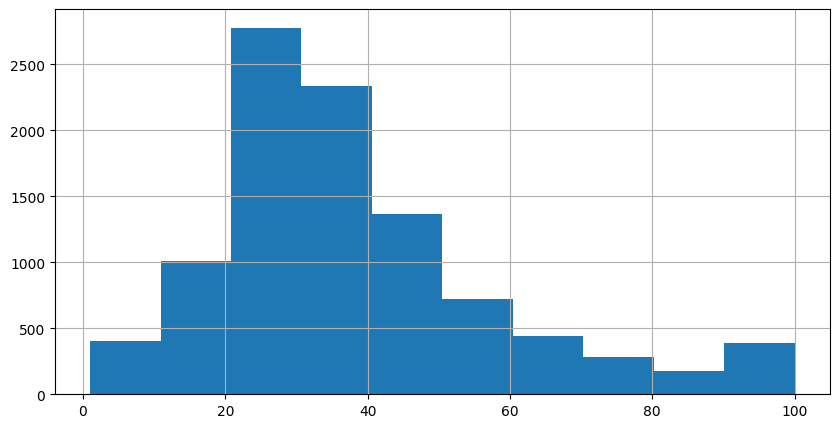

In [79]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [80]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

There are 100 unique values of Pawpularity score


Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

In [81]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

Let's check an example image to see what it looks like:

In [82]:
im = Image.open(train_df['path'][8])
width, height = im.size
print(width,height)

560 960


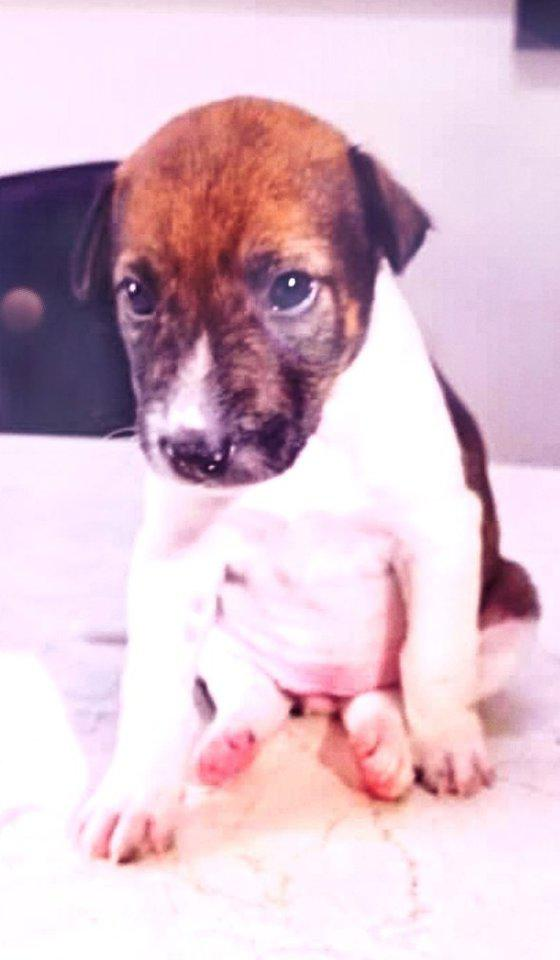

In [83]:
im

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [84]:
!ls -l /content/petfinder-pawpularity-score/train/4488cdaa0c8f1967f4f6ca94e26aa13f.jpg
train_df['path'].head()

-rw-r--r-- 1 root root 94941 Sep 22  2021 /content/petfinder-pawpularity-score/train/4488cdaa0c8f1967f4f6ca94e26aa13f.jpg


0    /content/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1    /content/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2    /content/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3    /content/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4    /content/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg
Name: path, dtype: object

In [86]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               #path=dataset_path,
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=32, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

FileNotFoundError: [Errno 2] No such file or directory: './/content/petfinder-pawpularity-score/train/4488cdaa0c8f1967f4f6ca94e26aa13f.jpg'

In [46]:
!ls -l .//content/petfinder-pawpularity-score/train/4488cdaa0c8f1967f4f6ca94e26aa13f.jpg

ls: cannot access './/content/petfinder-pawpularity-score/train/4488cdaa0c8f1967f4f6ca94e26aa13f.jpg': No such file or directory


In [44]:
dls.show_batch()

NameError: name 'dls' is not defined

# Model training

Let's train a Swin Transformer model as a baseline. We will use the wonderful timm package by Ross Wightman to define the model. Since this competition doesn't allow internet access, I have added the pretrained weights from timm as a dataset, and the below code cell will allow timm to find the file:

In [ ]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

Let's now define the model.

In [ ]:
model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

Let's also define the metric we will use. Note that we multiply by 100 to get a relevant RMSE for Pawpularity Score prediction, not prediction of the normalized score.

In [ ]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc. Let's define the `Learner` for this task, and also use mixed precision. Note that we use `BCEWithLogitsLoss` to treat this as a classification problem.

> Note: `AccumMetric` is used accumulate predictions from all the batches in the validation for calculating the metric. If `AccumMetric` is not used, then the metric is calculated per batch and averaged across all batches which is the _incorrect_ way of doing it for RMSE.

In [ ]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()

We are now provided with a Learner object. In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

In [ ]:
learn.lr_find(end_lr=3e-2)

Let's now fine-tune the model with the desired learning rate of 2e-5. We'll save the best model and use the early stopping callback.

In [ ]:
learn.fit_one_cycle(10, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = learn.to_fp32()

In [ ]:
learn.save('fine-tuned')

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

In [ ]:
learn.export()

## Inference

It's very simple to perform inference with fastai. We preprocess the test CSV in the same way as the train CSV, and the `dls.test_dl` function allows you to create test dataloader using the same pipeline we defined earlier.

In [ ]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

In [ ]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100
test_dl = dls.test_dl(test_df)

We can easily confirm that the test_dl is correct (the example test images provided are just noise so this is expected):

In [ ]:
test_dl.show_batch()

Now let's pass the dataloader to the model and get predictions. Here I am using 5x test-time augmentation which further improves model performance.

In [ ]:
preds, _ = learn.tta(dl=test_dl, n=5, beta=0)

Let's make a submission with these predictions!

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['Pawpularity'] = preds.float().numpy()*100
sample_df.to_csv('submission.csv',index=False)

Now, **WE ARE DONE!**

If you enjoyed this notebook, please give it an upvote.

Stay tuned for improvements to this notebook, potentially including a version that uses the metadata as well.

If you have any questions or suggestions, please leave a comment!